In [12]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from scipy.ndimage.measurements import label

from sklearn.externals import joblib
%matplotlib inline

# CRITERIA 1: Provide a Writeup / README that includes all the rubric points and how you addressed each one. You can submit your writeup as markdown or pdf.

## ANSWER: All the files used for the project are in the current Repository. The writeup is this current file. I have tried my best to make it easily readable. All the answers to the criteria mentioned in project Rubric are answered by "ANSWER:" heading.

In [13]:
###All the Functions used are in this cell

def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def single_img_features(img, colorspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if colorspace != 'RGB':
        if colorspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif colorspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif colorspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif colorspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif colorspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, colorspace='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    img = img.astype(np.float32)/255
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, colorspace=colorspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def slide_window(img, x_start_stop=[None, None], y_start_stop_Array = [5,10], 
                    xy_window_Array=[64,64], xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    xy_window = [10,10]
    window_list = []
    y_start_stop= [10,20]
    
    for i in range(len(y_start_stop_Array)):
        y_start_stop[0] = y_start_stop_Array[i][0]
        y_start_stop[1] = y_start_stop_Array[i][1]
        
        xy_window[0] = xy_window_Array[i][0]
        xy_window[1] = xy_window_Array[i][1]
        
        if x_start_stop[0] == None:
            x_start_stop[0] = 0
        if x_start_stop[1] == None:
            x_start_stop[1] = img.shape[1]
        if y_start_stop[0] == None:
            y_start_stop[0] = 0
        if y_start_stop[1] == None:
            y_start_stop[1] = img.shape[0]
        # Compute the span of the region to be searched    
        xspan = x_start_stop[1] - x_start_stop[0]
        yspan = y_start_stop[1] - y_start_stop[0]
        # Compute the number of pixels per step in x/y
        nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
        ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
        # Compute the number of windows in x/y
        nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
        ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
        nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
        ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
        # Initialize a list to append window positions to
        
        # Loop through finding x and y window positions
        # Note: you could vectorize this step, but in practice
        # you'll be considering windows one by one with your
        # classifier, so looping makes sense
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                # Calculate window position
                startx = xs*nx_pix_per_step + x_start_stop[0]
                endx = startx + xy_window[0]
                starty = ys*ny_pix_per_step + y_start_stop[0]
                endy = starty + xy_window[1]
                # Append window position to list
                window_list.append(((startx, starty), (endx, endy)))

        # Return the list of windows
    return window_list

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
def extract_features(imgs, colorspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=1, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
                
        # apply color conversion if other than 'RGB'
        if colorspace != 'RGB':
            if colorspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif colorspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif colorspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif colorspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif colorspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    box_List=[]
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                box_Array=((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                box_List.append(box_Array)
                
    return draw_img, box_List

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



In [15]:
### A look at Large Sets

cars1 = list(glob.iglob(r'C:\Users\Siddarth\Desktop\Udacity\CarND-Vehicle-Detection-master\Datasets\vehicles/**/*.png', recursive=True))
notcars1 = list(glob.iglob(r'C:\Users\Siddarth\Desktop\Udacity\CarND-Vehicle-Detection-master\Datasets\non-vehicles/**/*.png', recursive=True)) 

In [24]:
cars = cars1[:6000]
notcars = notcars1[:6000]

print ('Length of Original Car and NotCar Set Respectively:', len(cars1), len(notcars1))

Length of Original Car and NotCar Set Respectively: 8792 8968


# CRITERIA 2: Explain how (and identify where in your code) you extracted HOG features from the training images. Explain how you settled on your final choice of HOG parameters.

## ANSWER: The HOG features were extracted by the function get_hog_features in Cell 2. The parameters used for the HOG extraction are also specified below.

##         features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,              visualise=vis, feature_vector=feature_vec)



[ 0.43137255  0.60784316  0.77254903]
[70 73 92]


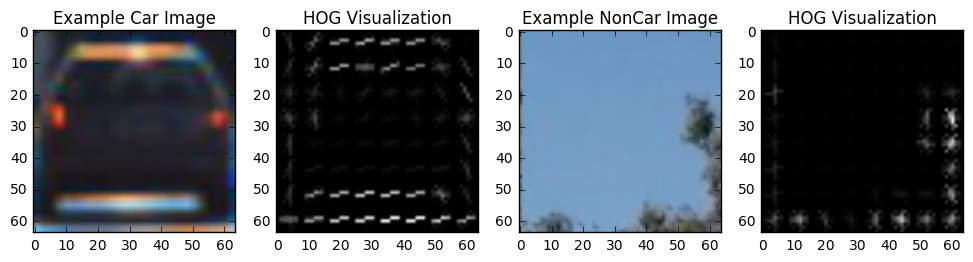

In [25]:
VehicleFile = r'Datasets/vehicles_smallset/cars1/10.jpeg'
NonVehicleFile = r'Datasets/non-vehicles/Extras/extra1.png'
image_V=mpimg.imread(VehicleFile)
image_NV = mpimg.imread(NonVehicleFile)

orient = 9
pix_per_cell = 8
cell_per_block = 2
gray_Vehicle = cv2.cvtColor(image_V, cv2.COLOR_RGB2GRAY)
gray_NonVehicle = cv2.cvtColor(image_NV, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray_Vehicle, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

features_NV, hog_image_NV = get_hog_features(gray_NonVehicle, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure(figsize=(12,12))
plt.subplot(141)
plt.imshow(image_V, cmap='gray')
plt.title('Example Car Image')

plt.subplot(142)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

plt.subplot(143)
plt.imshow(image_NV, cmap='gray')
plt.title('Example NonCar Image')

plt.subplot(144)
plt.imshow(hog_image_NV, cmap='gray')
plt.title('HOG Visualization')

print (image_NV[10,10])
print (image_V[10,10])

## I Played around with different values of all these parameters. The list shows the values that I played around with. 

## Particularly the color_space had quite a ahigh influence on the accuracy. The YCrCb color_space gave the best results. The SVC Accuracy is always 0.985 or better.

## The final parameters chosen are in the cell below.

In [26]:
### Parameters for further simulation

colorspace = 'YCrCb'
orient = 9
cell_per_block = 2  
hog_channel = 'ALL'
pix_per_cell = 8
spatial_size = (32,32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 656]
ystart = 400
ystop = 656
svc = LinearSVC()

y_start_stop_Array = [[400, 650]]

xy_window_Array= [[96,96]]

#y_start_stop_Array = [[400, 650],[400,500]]

#xy_window_Array= [[96,96],[75,75]]

##y_start_stop_Array = [[400, 650],[400,500],[400,500]]

##xy_window_Array= [[96,96],[75,75],[50,50]]


# CRITERIA 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).
## ANSWER: The cells below describe the training process to classify HOG features. A Linear SVC and Standard Scaler were used to classify the HOG Features

X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)
svc = LinearSVC()
svc.fit(X_train, y_train)

This code does the job of training a aclassifier

In [20]:
print ('HOG Channel,  pix_per_cell,  cell_per_block,  orient,  colorspace,  SVC Accuracy,  length of training,  time')
t=time.time()
car_features = extract_features(cars, colorspace=colorspace, spatial_size=spatial_size, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, colorspace=colorspace, spatial_size=spatial_size, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)
svc = LinearSVC()

# Use a linear SVC 

svc.fit(X_train, y_train)
t2 = time.time()
svcAccuracy = round(svc.score(X_test, y_test), 4)
print (hog_channel,    pix_per_cell,     cell_per_block,     orient,     colorspace, svcAccuracy,     len(X_train[0]),     round(t2-t, 2))

import pickle
SavedModel = pickle.dumps(svc)

from sklearn.externals import joblib
joblib.dump(svc, 'SavedSVC.pkl')


HOG Channel,  pix_per_cell,  cell_per_block,  orient,  colorspace,  SVC Accuracy,  length of training,  time
ALL 8 2 9 YCrCb 0.9942 8460 172.44


['SavedSVC.pkl']

In [29]:
svc = joblib.load('SavedSVC.pkl') 

# CRITERIA 4: Describe how (and identify where in your code) you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows?

## ANSWER: The cell below shows the plot of sliding windows. I played around with three window sizes at varying y_start and y_stop values. The array I started with is as follows.

## y_start_stop_Array = [[400, 650],[400,500],[400,500]]

## xy_window_Array= [[96,96],[75,75],[50,50]]

## Finally I noticed that the the window size of 96,96 did the job pretty well for the problem at hand and is morever computationally inexpensive. I chose this Size

## My classifier was having particular problem in detecting the white car.

## Also I neglected the Left side of the image as there were no cars in this region in the video.

68


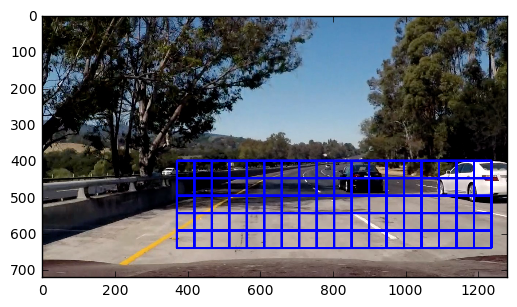

In [27]:
TestImage = 'test_images/test5.jpg'
image = mpimg.imread(TestImage)

windows = slide_window(image, x_start_stop=[370, None], y_start_stop_Array = y_start_stop_Array, 
                    xy_window_Array = xy_window_Array, xy_overlap=(0.5, 0.5))
print (len(windows))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

# CRITERIA 5: Show some examples of test images to demonstrate how your pipeline is working. How did you optimize the performance of your classifier?

## ANSWER: The Picture below shows the car identification by the code. Both the cars can be recognised clearly by the classifier. I tried to optimize the classifier by a robust feature extraction. Particularly the YCrCb channel proved helpful.

## A more robust SVC classifier or a combination of SVC+NN could be able tto increase the accuracy.

0.0 Seconds to train SVC...
Test Accuracy of SVC =  0.9942


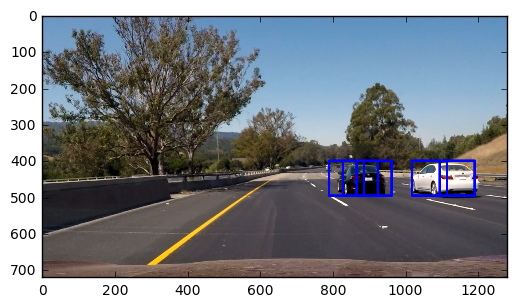

In [31]:
### TODO: Tweak these parameters and see how the results change.
TestImage = 'test_images/test6.jpg'
image = mpimg.imread(TestImage)

t=time.time()
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

#image = mpimg.imread(TestImage)
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[370, None], y_start_stop_Array = y_start_stop_Array, 
                    xy_window_Array = xy_window_Array, xy_overlap=(0.6, 0.6))

hot_windows = search_windows(image, windows, svc, X_scaler, colorspace=colorspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)


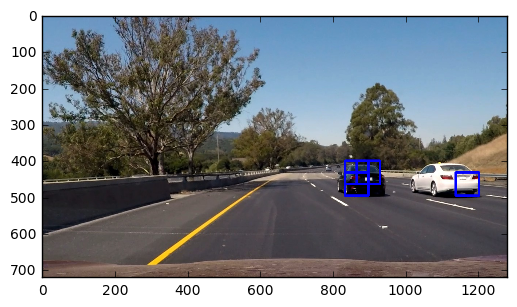

In [32]:
scale = 1

TestImage = 'test_images/test6.jpg'
image = mpimg.imread(TestImage)

out_img, box_List = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
plt.imshow(out_img)

## CRITERIA 7: Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

## ANSWER: The heat map technique with a threshold was used to identify false positives. In Video I took a mean of previous 5-8 frames for detection of false positives.

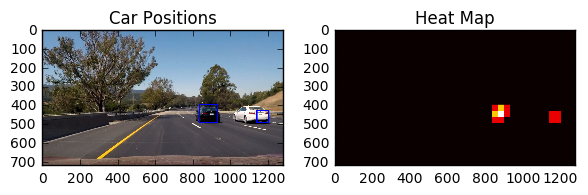

In [33]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)
heat = add_heat(heat,box_List)
# Apply threshold to help remove false positives
heat = apply_threshold(heat,0.5)
# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


Max heat Value: 0.0
Max heat Value: 1.0
Max heat Value: 3.0
Max heat Value: 3.0
Max heat Value: 3.0


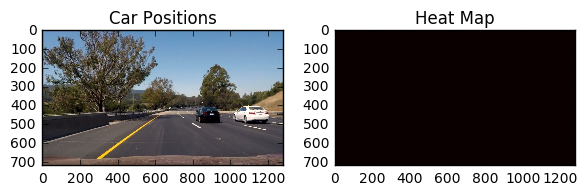

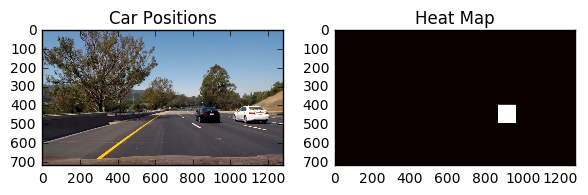

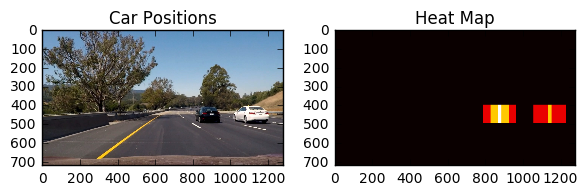

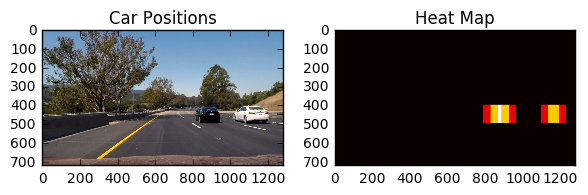

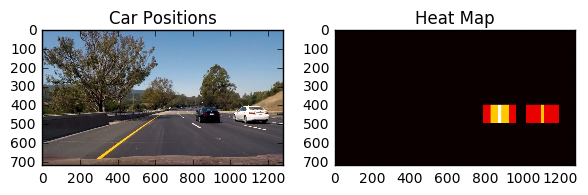

In [35]:
import os

TestDir ='test_images_2/'
Testim = os.listdir(TestDir)

for eachTestImg in Testim[1:]:
    lineToread = TestDir+'\\'+ eachTestImg
    img = plt.imread(lineToread)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    windows = slide_window(img, x_start_stop=[370, None], y_start_stop_Array = y_start_stop_Array, 
                        xy_window_Array = xy_window_Array, xy_overlap=(0.6, 0.6))

    box_List = search_windows(img, windows, svc, X_scaler, colorspace=colorspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    heat = add_heat(heat,box_List)
    print ('Max heat Value:', np.max(heat))
    heat = apply_threshold(heat,0.99)  
    heatmap = np.clip(heat, 0, 255)    
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(image)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()

    

## CRITERIA 6: Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)

## ANSWER: The video in Repository by name: output_window1.mp4 

In [36]:
Heat_Img_List=[]

def pipeline_V2(img):
    windows = slide_window(img, x_start_stop=[370, None], y_start_stop_Array = y_start_stop_Array, 
                        xy_window_Array = xy_window_Array, xy_overlap=(0.6, 0.6))

    box_List = search_windows(img, windows, svc, X_scaler, colorspace=colorspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    #window_img = draw_boxes(img, hot_windows, color=(0, 0, 255), thick=6)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, box_List)
    Heat_Img_List.append(heat)
    
    ClearImg = np.mean(Heat_Img_List[-6:],axis=0)
    
    heat = apply_threshold(ClearImg,0.9)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from IPython.display import display
output = 'output_window_7.mp4'
clip1 = VideoFileClip("project_video.mp4")

output_clip = clip1.fl_image(pipeline_V2) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_window_7.mp4
[MoviePy] Writing video output_window_7.mp4


  7%|██▋                                     | 86/1261 [01:47<28:56,  1.48s/it]

# CRITERIA 8: Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

## ANSWER: The major issues i faced during implementation of this project was getting the parameters right for the car detection. I played around with different parameters to find the best sets.

## The pipeline can be improved in the following ways.
## 1. a Neuralnetwork can be implemented to make the finding of the cars more robust.
## 2. I just tried here with Linear SVC withut changing any of the parameters. A better set of SVC parameters can  increase the accuracy substantially.
## 3. To make the pipeline more robust,a combination of techniques from first chapter can be used like gradient detection and so on.